# Определение перспективного тарифа для телеком-компании

* Цель исследования-определить наиболее прибыльный тариф
* Задача: сделать предварительный анализ тарифов на небольшой выборке клиентов
* Описание данных: В  распоряжении данные 500 пользователей : кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год
* Оператор всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
 Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. 

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import seaborn as sns

## 1.Ознакомление с данными

In [2]:
calls = pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv') 
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv', index_col=0) # Данные были сохранены с указанием индекса pd.DataFrame().to_csv(..., index=column)
messages =  pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv')             # Для того чтобы данные  прочитались корректно был добавлен index_col=0
tariffs = pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv')
users =  pd.read_csv('https://code.s3.yandex.net/datasets/users.csv')

In [3]:
calls.head(),internet.head(), messages.head(), tariffs.head(), users.head()

(       id   call_date  duration  user_id
 0  1000_0  2018-07-25      0.00     1000
 1  1000_1  2018-08-17      0.00     1000
 2  1000_2  2018-06-11      2.85     1000
 3  1000_3  2018-09-21     13.80     1000
 4  1000_4  2018-12-15      5.18     1000,
        id  mb_used session_date  user_id
 0  1000_0   112.95   2018-11-25     1000
 1  1000_1  1052.81   2018-09-07     1000
 2  1000_2  1197.26   2018-06-25     1000
 3  1000_3   550.27   2018-08-22     1000
 4  1000_4   302.56   2018-09-24     1000,
        id message_date  user_id
 0  1000_0   2018-06-27     1000
 1  1000_1   2018-10-08     1000
 2  1000_2   2018-08-04     1000
 3  1000_3   2018-06-16     1000
 4  1000_4   2018-12-05     1000,
    messages_included  mb_per_month_included  minutes_included  \
 0                 50                  15360               500   
 1               1000                  30720              3000   
 
    rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
 0              

In [4]:
calls.dtypes, internet.dtypes, messages.dtypes, tariffs.dtypes, users.dtypes

(id            object
 call_date     object
 duration     float64
 user_id        int64
 dtype: object,
 id               object
 mb_used         float64
 session_date     object
 user_id           int64
 dtype: object,
 id              object
 message_date    object
 user_id          int64
 dtype: object,
 messages_included         int64
 mb_per_month_included     int64
 minutes_included          int64
 rub_monthly_fee           int64
 rub_per_gb                int64
 rub_per_message           int64
 rub_per_minute            int64
 tariff_name              object
 dtype: object,
 user_id        int64
 age            int64
 churn_date    object
 city          object
 first_name    object
 last_name     object
 reg_date      object
 tariff        object
 dtype: object)

In [5]:
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

<b> Вывод</b></p>
При ознакомлении с данными были выявлены некоторые моменты которые нужно исправить, а именно:</p>
1) Округлить данные и привести к нужным типам <p>
2) Заменить пропуски<p>
3) Добавить столбцы с необходимыми расчетами<p>
4) Объединить таблицы для последующего анализа<p>

## 2.Подготовка данных

Приведем данные к нужному формату

In [6]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['month'] = calls['call_date'].dt.month

Сгруппируем данные для последующего объединения и дальнейшего преобразования

In [9]:
calls = calls.groupby(['user_id','month'])['duration'].sum().reset_index()
calls.head()

,user_id,month,duration
0,1000,5,150.06
1,1000,6,158.90
2,1000,7,318.80
3,1000,8,389.87
4,1000,9,440.14


Округлим значения по условию оператора в большую сторону и приведем к целочисленному формату

In [12]:
calls['duration'] = np.ceil(calls['duration'])
calls['duration'] = calls['duration'].astype(int)
calls.head()

,user_id,month,duration
0,1000,5,151
1,1000,6,159
2,1000,7,319
3,1000,8,390
4,1000,9,441


Приведем данные к формату времени и выведем в отдельный столбец месяц для дальнейших расчетов и объединения таблиц

In [13]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['month'] = internet['session_date'].dt.month
internet = internet.groupby(['user_id','month'])['mb_used'].sum().reset_index()
internet.head()

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


Мегабайты необходимо округлить и привести даннеы к целочисленному формату 

In [14]:
internet['mb_used'] = internet['mb_used'] / 1024
internet['mb_used'] = np.ceil(internet['mb_used']) * 1024
internet['mb_used'] = internet['mb_used'].astype(int)
internet.head()

,user_id,month,mb_used
0,1000,5,3072
1,1000,6,23552
2,1000,7,14336
3,1000,8,14336
4,1000,9,15360


Тип данных нужно изменить на datetime и вывести месяц 

In [16]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['month'] = messages['message_date'].dt.month
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


Данные необходимо сгруппировать по user_id, month

In [17]:
messages = messages.groupby(['user_id', 'month'])['id'].count().reset_index()
messages = messages.rename(columns={'id':'messages_count'}) 
messages.head()

,user_id,month,messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


Изменим тип данных на datetime

In [18]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

Заполним пропуски

In [20]:
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Поскольку многие тарифы на момент выгрузки данных еще действовали, то как вариант можно заменить пропуски на последний день 2018 года


In [23]:
import datetime
users = users.fillna(datetime.datetime(2018,12,31))
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,2018-12-31,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,2018-12-31,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,2018-12-31,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,2018-12-31,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [24]:
users.dtypes

user_id                int64
age                    int64
churn_date    datetime64[ns]
city                  object
first_name            object
last_name             object
reg_date      datetime64[ns]
tariff                object
dtype: object

Объединим таблицы 

In [26]:
df1 = calls.merge(messages, on=['user_id', 'month'], how='outer')
df2 = df1.merge(internet, on=['user_id', 'month'], how='outer')
df = df2.merge(users, on='user_id', how='left')
df.head()

,user_id,month,duration,messages_count,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,151.0,22.0,3072.0,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,159.0,60.0,23552.0,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,319.0,75.0,14336.0,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,390.0,81.0,14336.0,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,441.0,57.0,15360.0,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [27]:
len(df['user_id'].unique()) # Было потеряно два пользователя при объединении данных

498

In [43]:
for i in users['user_id'].unique(): # id пользователей, которые были потеряны при объединении данных
    if i not in df['user_id'].unique():
        print(i)

1128
1371


In [50]:
users.query('user_id == 1128 or user_id == 1371') 

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


In [73]:
df.isna().sum() # Есть пропуски в объединенной таблице

user_id             0
month               0
duration           40
messages_count    497
mb_used            11
age                 0
churn_date          0
city                0
first_name          0
last_name           0
reg_date            0
tariff              0
dtype: int64

In [74]:
df.fillna(0, inplace=True) # Заменим пропуски на нули. В дальнейшем их можно отфильтровать 

In [75]:
df.head()

,user_id,month,duration,messages_count,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,151.0,22.0,3072.0,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,159.0,60.0,23552.0,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,319.0,75.0,14336.0,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,390.0,81.0,14336.0,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,441.0,57.0,15360.0,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [77]:
df.dtypes # Некторые типы данных неподходящие 

user_id                    int64
month                      int64
duration                 float64
messages_count           float64
mb_used                  float64
age                        int64
churn_date        datetime64[ns]
city                      object
first_name                object
last_name                 object
reg_date          datetime64[ns]
tariff                    object
dtype: object

In [78]:
df['messages_count'] = df['messages_count'].astype(int)
df['mb_used'] = df['mb_used'].astype(int)
df['duration'] = df['duration'].astype(int) 

Чтобы добавить столбец с расчетом прибыли в зависимости от тарифа нужно создать функцию для строки 

In [79]:
def calc(df):
    
    tariff = df['tariff']
    
    if tariff == 'smart':
        
        if df['messages_count'] > 50 and df['duration'] <= 500 and df['mb_used'] <= 15360:
            revenue = (df['messages_count'] - 50) * 3 + 550
        if df['messages_count'] <= 50 and df['duration'] > 500 and df['mb_used'] <= 15360:
            revenue = (df['duration'] - 500) * 3 + 550
        if df['messages_count'] <= 50 and df['duration'] <= 500 and df['mb_used'] > 15360:  
            revenue = (df['mb_used'] - 15360) / 1024 * 200 + 550
        if df['messages_count'] <= 50 and df['duration'] <= 500 and df['mb_used'] <= 15360: 
            revenue = 550
        if df['messages_count'] <= 50 and df['duration'] > 500 and df['mb_used'] > 15360:
            revenue = (df['duration'] - 500) * 3 + (df['mb_used'] - 15360) / 1024 * 200 + 550
        if df['messages_count'] > 50 and df['duration'] <= 500 and df['mb_used'] > 15360: 
            revenue = (df['messages_count'] - 50) * 3 + (df['mb_used'] - 15360) / 1024 * 200 + 550
        if df['messages_count'] > 50 and df['duration'] > 500 and df['mb_used'] <= 15360: 
            revenue = (df['messages_count'] - 50) * 3 + (df['duration'] - 500) * 3 + 550
        if df['messages_count'] > 50 and df['duration'] > 500 and df['mb_used'] > 15360:
            revenue = (df['duration'] - 500) * 3 + (df['messages_count'] - 50) * 3 + (df['mb_used'] - 15360) / 1024 * 200 + 550
            
    if tariff == 'ultra':
        
        if df['messages_count'] > 1000 and df['duration'] <= 3000 and df['mb_used'] <= 30720:
            revenue = (df['messages_count'] - 1000) * 1 + 1950
        if df['messages_count'] <= 1000 and df['duration'] > 3000 and df['mb_used'] <= 30720:
            revenue = (df['duration'] - 3000) * 1 + 1950
        if df['messages_count'] <= 1000 and df['duration'] <= 3000 and df['mb_used'] > 30720:  
            revenue = (df['mb_used'] - 30720) / 1024 * 150 + 1950
        if df['messages_count'] <= 1000 and df['duration'] <= 3000 and df['mb_used'] <= 30720: 
            revenue = 1950
        if df['messages_count'] <= 1000 and df['duration'] > 3000 and df['mb_used'] > 30720:
            revenue = (df['duration'] - 3000) * 1 + (df['mb_used'] - 30720) / 1024 * 150 + 1950
        if df['messages_count'] > 1000 and df['duration'] <= 3000 and df['mb_used'] > 30720: 
            revenue = (df['messages_count'] - 1000) * 1 + (df['mb_used'] - 30720) / 1024 * 150 + 1950
        if df['messages_count'] > 1000 and df['duration'] > 3000 and df['mb_used'] <= 30720: 
            revenue = (df['messages_count'] - 1000) * 1 + (df['duration'] - 3000) * 1 + 1950
        if df['messages_count'] > 1000 and df['duration'] > 3000 and df['mb_used'] > 30720:
            revenue = (df['duration'] - 3000) * 1 + (df['messages_count'] - 1000) * 1 + (df['mb_used'] - 30720) / 1024 * 150 + 1950
   
    return revenue
        

In [81]:
df['revenue'] = df.apply(calc, axis=1) # Применяем функцию построчно

In [82]:
df.dtypes

user_id                    int64
month                      int64
duration                   int32
messages_count             int32
mb_used                    int32
age                        int64
churn_date        datetime64[ns]
city                      object
first_name                object
last_name                 object
reg_date          datetime64[ns]
tariff                    object
revenue                  float64
dtype: object

In [83]:
df['revenue'] =  df['revenue'].astype(int)

In [84]:
df.head()

,user_id,month,duration,messages_count,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,revenue
0,1000,5,151,22,3072,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950
1,1000,6,159,60,23552,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950
2,1000,7,319,75,14336,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950
3,1000,8,390,81,14336,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950
4,1000,9,441,57,15360,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950


<b> Вывод</b></p>
На этапе подготовки данных были окргулены необходимые значения согласно условию оператора и приведены в нужный формат. Также были приведены к временному формату данные дат. Для последующего объединения данных и анализа в таблицах были выведены месяца. Кроме того, были добавлены данные с расчетами прибыли. Для этоого была создана функция и применена построчно. Данные были объединены и подготовлены для анализа.

## 3. EDA

Следует рассмотреть статистики данных, сгруппированных по тарифному признаку. На данном этапе будут сравниваться  распределения средних значений, продолжительности звонка, мегабайт и сообщений, а также значения их дисперсий и стандартных отклонений.

In [86]:
smart_users = df.query('tariff == "smart"')
ultra_users = df.query('tariff == "ultra"')
smart_pivot = smart_users.pivot_table(index='month', values = ['duration','messages_count', 'mb_used'], aggfunc=['mean', 'var', 'std'])
smart_pivot = smart_pivot.round()
ultra_pivot = ultra_users.pivot_table(index='month', values = ['duration','messages_count', 'mb_used'], aggfunc=['mean', 'var', 'std'])
ultra_pivot = ultra_pivot.round()

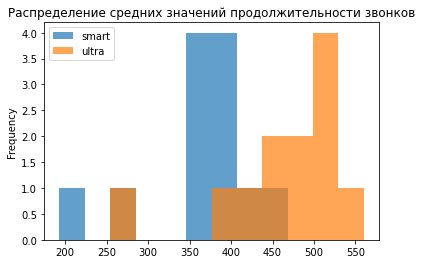

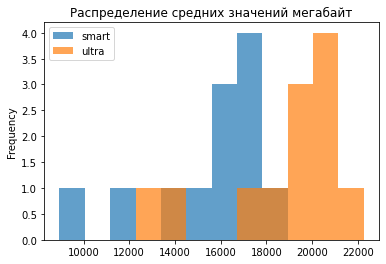

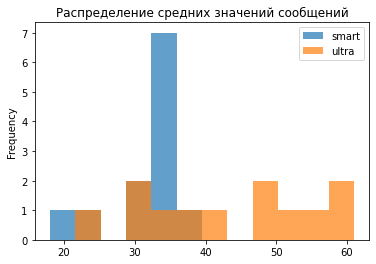

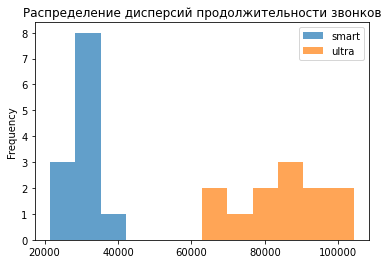

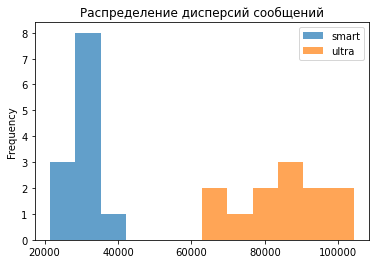

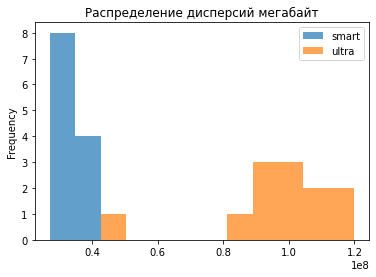

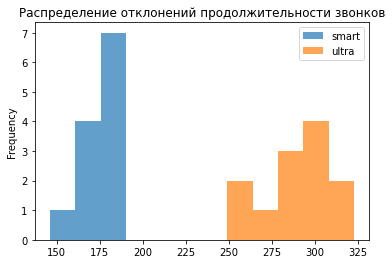

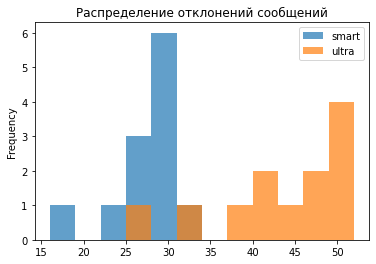

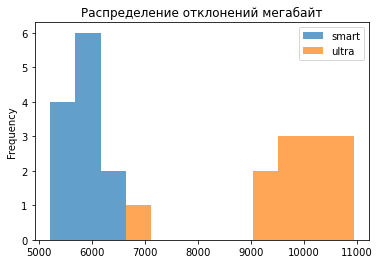

In [87]:
smart_duration = smart_pivot['mean','duration']
ultra_duration = ultra_pivot['mean','duration']

duration_plot = pd.DataFrame({'smart':smart_duration, 'ultra':ultra_duration})
duration_plot.plot(kind='hist', bins=12, alpha=0.7, title='Распределение средних значений продолжительности звонков')

mb_used_plot = pd.DataFrame({'smart':smart_pivot['mean','mb_used'], 'ultra':ultra_pivot['mean','mb_used']})
mb_used_plot.plot(kind='hist', bins=12, alpha=0.7, title='Распределение средних значений мегабайт')

messages_plot = pd.DataFrame({'smart':smart_pivot['mean','messages_count'], 'ultra':ultra_pivot['mean','messages_count']})
messages_plot.plot(kind='hist', bins=12, alpha=0.7, title='Распределение средних значений сообщений')

duration_plot_var = pd.DataFrame({'smart':smart_pivot['var','duration'], 'ultra':ultra_pivot['var','duration']})
duration_plot_var.plot(kind='hist', bins=12, alpha=0.7, title='Распределение дисперсий продолжительности звонков')

messages_plot_var = pd.DataFrame({'smart':smart_pivot['var','messages_count'], 'ultra':ultra_pivot['var','messages_count']})
duration_plot_var.plot(kind='hist', bins=12, alpha=0.7, title='Распределение дисперсий сообщений')

mb_plot_var = pd.DataFrame({'smart':smart_pivot['var','mb_used'], 'ultra':ultra_pivot['var','mb_used']})
mb_plot_var.plot(kind='hist', bins=12, alpha=0.7, title='Распределение дисперсий мегабайт')

duration_std = pd.DataFrame({'smart':smart_pivot['std','duration'], 'ultra':ultra_pivot['std','duration']})
duration_std.plot(kind='hist', bins=12, alpha=0.7, title='Распределение отклонений продолжительности звонков')

messages_std = pd.DataFrame({'smart':smart_pivot['std','messages_count'], 'ultra':ultra_pivot['std','messages_count']})
messages_std.plot(kind='hist', bins=12, alpha=0.7, title='Распределение отклонений сообщений')

mb_std = pd.DataFrame({'smart':smart_pivot['std','mb_used'], 'ultra':ultra_pivot['std','mb_used']})
mb_std.plot(kind='hist', bins=12, alpha=0.7, title='Распределение отклонений мегабайт')
print()

Распределения демонстрируют существенные отличия в данных. Средние значения двух тарифов распределений достаточно удалены друг от друга. В целом массивы значений также показывают значительные различия. В каждом распределении тариф "Ультра" смещен относительно тарифа "Смарт" в большую сторону. Существуют некоторые пересечения, но можно сделать предположение, что данные по тарифам имеют существенные различия. Поэтому можно проверить гипотезу о равенстве средних прибылей для тарифов.

Далее можно сравнить средние значения показателей по месяцам при помощи столбчатой диаграммы.

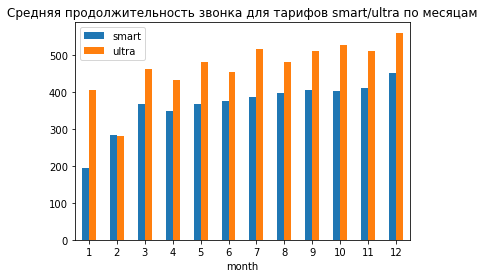

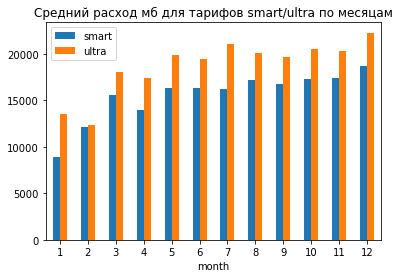

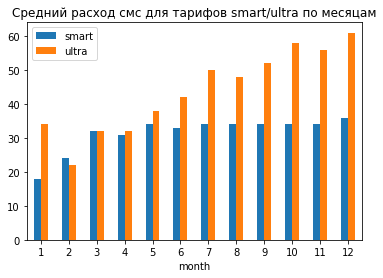

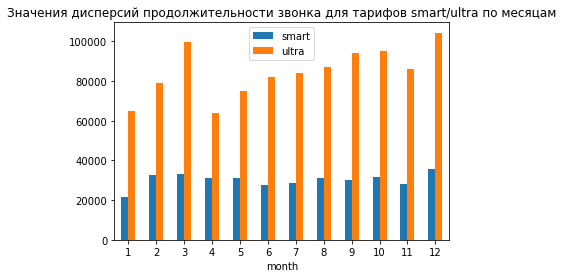

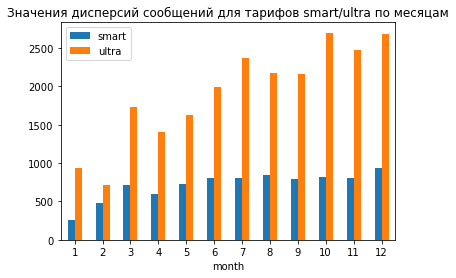

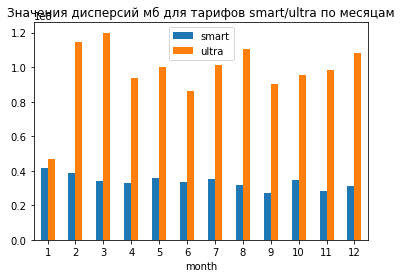

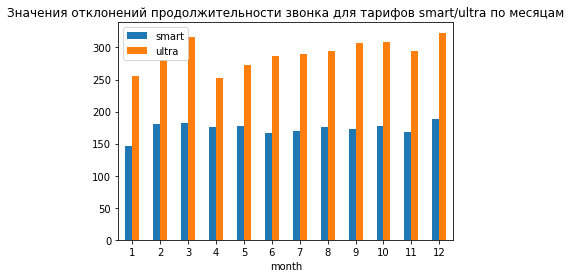

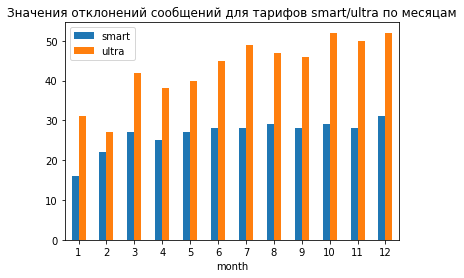

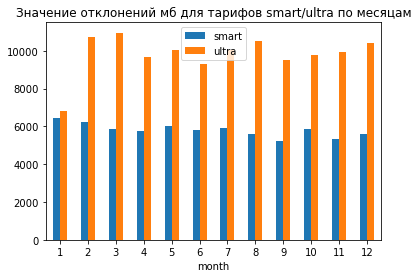

In [89]:
duration_plot.plot.bar(rot=0, title='Средняя продолжительность звонка для тарифов smart/ultra по месяцам')

mb_used_plot.plot.bar(rot=0, title='Средний расход мб для тарифов smart/ultra по месяцам')

messages_plot.plot.bar(rot=0, title='Средний расход смс для тарифов smart/ultra по месяцам')

duration_plot_var.plot.bar(rot=0, title='Значения дисперсий продолжительности звонка для тарифов smart/ultra по месяцам')

messages_plot_var.plot.bar(rot=0, title='Значения дисперсий сообщений для тарифов smart/ultra по месяцам')

mb_plot_var.plot.bar(rot=0, title='Значения дисперсий мб для тарифов smart/ultra по месяцам')

duration_std.plot.bar(rot=0, title='Значения отклонений продолжительности звонка для тарифов smart/ultra по месяцам')

messages_std.plot.bar(rot=0, title='Значения отклонений сообщений для тарифов smart/ultra по месяцам')

mb_std.plot.bar(rot=0, title='Значение отклонений мб для тарифов smart/ultra по месяцам')
print()

Графики показывают, что значения  тарифов по месяцам также значительно отличаются. Значения тарифа "Ультра" почти для каждого месяца и для каждого параметра больше чем для тарифа "Смарт"

<b> Вывод</b></p>
На этапе анализа данных было выявлено, что распределения демонстрируют существенные отличия в данных. Средние значения двух тарифов распределений достаточно удалены друг от друга. В целом массивы значений также показывают значительные различия. В каждом распределении тариф "Ультра" смещен относительно тарифа "Смарт" в большую сторону. Существуют некоторые пересечения, но можно сделать предположение, что данные по тарифам имеют существенные различия. Поэтому можно проверить гипотезу о равенстве средних прибылей для тарифов.Сравнение значений по месяцам показало, что значения  тарифов по месяцам также значительно отличаются. Значения тарифа "Ультра" почти для каждого месяца и для каждого параметра больше чем для тарифа "Смарт".

## 4. Проверка гипотез на статистические различия

1)Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;</p>
2)Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

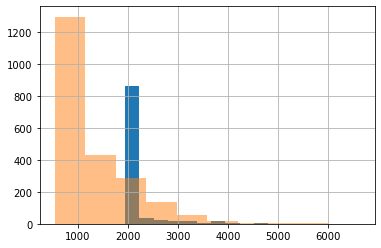

In [90]:
ultra_users['revenue'].hist(alpha=1)
smart_users['revenue'].hist(alpha=0.5)
print()

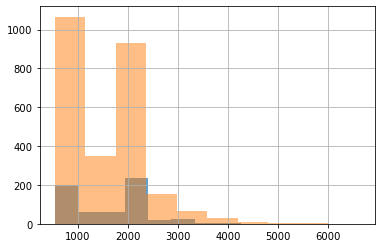

In [91]:
df.query('city == "Москва"')['revenue'].hist(alpha=0.7)
df.query('city != "Москва"')['revenue'].hist(alpha=0.5)
print()

Проверим гипотезу о равенстве средних двух выборок. <p>
H0: Средняя выручка "Ультра" = Средней выручке "Смарт"<p>
Н1: Средняя выручка "Ультра"!= Средней выручке "Смарт"<p>


In [92]:
alpha = 0.05 

sample_1 = ultra_users['revenue']
sample_2 = smart_users['revenue']
results_1 = st.ttest_ind( sample_1, sample_2)

print('p-значение: ', results_1.pvalue)

if results_1.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.513773301175091e-178
Отвергаем нулевую гипотезу


In [93]:
sample_1.mean() # Ultra

2070.1522842639592

In [94]:
sample_2.mean() # Smart

1257.5886047554957

 Тест показал, что гипотезу о равенстве выборок можно отвергнуть. Таким образом, можно сделать вывод о том, что скорее всего средняя выручка с тарифа "Ультра" больше чем средняя выручка с тарифа "Смарт", основываясь на средних выборок. Значит тариф "Ультра" выгоднее для оператора.

Полученное p-value говорит о том, что вероятно получить такие или большие различия в данных  случайно крайне малы. Это дает основание отвергнуть нулевую гипотезу о равенстве средних выручки двух тарифов. 

Проверим гипотезу о равенстве средних выручки двух тарифов для абонентов из Москвы и из других регионов.<p>
Н0: Средняя выручка абонентов из Москвы = Средней выручке абонентов из других регионов<p>
Н1: Средняя выручка абонентов из Москвы != Средней выручке абонентов из других регионов<p>

In [95]:
alpha = 0.05 

sample_3 = df.query('city == "Москва"')['revenue']
sample_4 = df.query('city != "Москва"')['revenue']
results_2 = st.ttest_ind( sample_3, sample_4)

print('p-значение: ', results_2.pvalue)

if results_2.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.4836504757759247
Не получилось отвергнуть нулевую гипотезу


Полученное p-value говорит о том, что  вероятность получить такие либо большие различия случайно в данных выше порогового значения. Поэтому нет оснований отвергнуть нулевую гипотезу о равенстве средних выручки для абонентов из Москвы и других регионов.

Этап проверки гипотез выявил, что гипотезу о равенстве средних значений  выручки для  тарифов "Смарт" и "Ультра" можно отвергнуть. Что может говорить об их различии.

## 5. Общий вывод

В процессе выполнения проекта была поэтапно проведена работа над данными для выполнения поставленных задач заказчика. На этапе ознакомления с данными были выявлены некоторые недостатки в данных и намечен алгоритм их подготовки для дальнейшего анализа. На этапе подготовки данных данные были приведены к нужным типам,объединены, были заполнены пропуски, проведены необходимые расчеты и добавлены в общую таблицу. На этапе анализа данных было выявлено, что распределения демонстрируют существенные отличия в данных. 
* Средние значения двух тарифов распределений достаточно удалены друг от друга. В целом массивы значений также показывают значительные различия. 
* В каждом распределении тариф "Ультра" смещен относительно тарифа "Смарт" в большую сторону. Существуют некоторые пересечения, но можно сделать предположение, что данные по тарифам имеют существенные различия. Поэтому можно проверить гипотезу о равенстве средних прибылей для тарифов.
* Сравнение значений по месяцам показало, что значения  тарифов по месяцам также значительно отличаются. Значения тарифа "Ультра" почти для каждого месяца и для каждого параметра больше чем для тарифа "Смарт". 
* Проверка гипотез показала, что гипотезу о равенстве средних выручки тарифов "Смарт" и "Ультра" можно отвергнуть. Что говорит о существенных различиях этих совокупностей.Кроме того, тест показал, что гипотезу о равенстве выборок можно отвергнуть. 
* Таким образом, можно сделать вывод о том, что скорее всего средняя выручка с тарифа "Ультра" больше чем средняя выручка с тарифа "Смарт", основываясь на средних выборок. 
* Значит тариф "Ультра" выгоднее для опрератора. Гипотезу о равенстве средних выручки для абонентов из Москвы и других регионов нет оснований отвергнуть. Что говорит о вероятностном сходстве этих совокупностей. 